## In this study, we propose discrete VAE. Generative model is as follows:


In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle

In [2]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [3]:
def permute(X, y=None):
    n_all_cases = X.shape[0]
    perm = np.arange(n_all_cases)
    np.random.shuffle(perm)
    if y is not None:
        return X[perm], y[perm]
    else:
        return X[perm], None

In [4]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [5]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    m, sd = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))


    plt.subplot(2, 2, 1)
    plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.scatter(sd[:,0], sd[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
    plt.colorbar()

    Z = np.random.normal(m,sd)
    plt.subplot(2, 2, 4)
    plt.scatter(Z[:,0], Z[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.show()

In [36]:
def plot_many_images(images, labels):

    ROW = 4
    COLUMN = 3
    for i in range(ROW * COLUMN):
        # train[i][0] is i-th image data with size 28x28
        image = images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        # train[i][1] is i-th digit label
        plt.title('label = {}'.format(labels[i]))
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots
    #plt.savefig('images/mnist_plot.png')
    plt.show()

### Import MNIST

In [6]:
mnist = tf.keras.datasets.mnist

### Load data

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
X = np.concatenate((X_train, X_test), axis=0)

In [9]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [10]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [11]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [12]:
n_classes = onehot_encoded.shape[1]

In [13]:
X = (X > 0.5).astype(np.float32)

In [14]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

### Utility functions

In [16]:
def get_log_folder():
    now = datetime.datetime.now()
    day_of_the_year=now.strftime("%d_%m_%Y")
    suff = now.strftime("%Y%m%d%H%M%S")
    #print(now.strftime("%Y%m%d%H%M%S"))
    log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
    return log_folder

In [17]:
def calculate_accuracy_np(y_pred, y_true):
    predicted_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)
    cond_correct = predicted_class == true_class
    return np.mean(cond_correct.astype(int))

In [18]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [19]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

### Build neural network

In [20]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
            initializer = tf.contrib.layers.xavier_initializer()
            self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [57]:
class VClassifier:
    
    def encode(self, X, input_dim, hidden_dims):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            h = DenseLayer(in_dim, h_dim)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = hidden_dims[-1]
        self.encoder_layers.append(DenseLayer(in_dim, middle_layer_dim, f=lambda x: x))
        
        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)
            
        logits = current_value

        return tf.math.softmax(tf.div(logits,100.0), axis=1)
    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            h = DenseLayer(in_dim, hidden_dim)
            decoder_layers.append(h)
            in_dim = hidden_dim

        decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node
    
    def sample_eps(self, shape):
        return  tf.random_normal(shape=shape, mean=0, stddev=1, 
                               dtype=tf.float32)

    def __init__(self, x_dim, hidden_dims, log_folder):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.layer = 1
        self.cum_thetas = []
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        
        self.Z = self.encode(self.X, x_dim, hidden_dims)
        
        #decoder
        self.logits = self.decode(self.Z, x_dim, hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)

        with tf.name_scope('COST'):
            expected_log_likelihood_2 = -tf.reduce_sum(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits), 
                axis=1
            )
            
            exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
            tf.summary.scalar("loglik_2", exp_loglik_2)
            
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-exp_loglik_2)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, epochs=30, batch_sz=64):
        #costs=[]
        n_batches = len(X_train) // batch_sz
        print("n_batches:", n_batches)

        iteration = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, _ = permute(X_train)
            for j in range(n_batches):
                batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
#                 batch_z = y_train[j * batch_sz:(j + 1) * batch_sz]
                self.sess.run(self.train_op, feed_dict={self.X: batch_x})
                if j % 100 == 0:
                    s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x})
                    self.writer_train.add_summary(s, iteration)

                iteration += 1

    def predict(self, x):
        z = self.sess.run(self.Z, feed_dict={self.X: x})
        print("z.shape={}".format(z.shape))
        y_pred = self.sess.run(self.posterior_predictive_probs, feed_dict={self.Z: z})
        return y_pred, z
    
#     def encode_image(self, x):
#         z = self.sess.run([self.Z], feed_dict={self.X: x})
#         return z


### Supervised VAE

In [64]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    hidden_dims=[256, 128, 10], 
    log_folder=log_folder
)
model_supervised.fit(X_train, epochs=3)


Starting autoencoder. Log folder=/tmp/class_vae/deep/18_04_2019/20190418112441


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
epoch: 1
epoch: 2


In [65]:
x_img, latent_var = model_supervised.predict(X_train)

z.shape=(63000, 10)


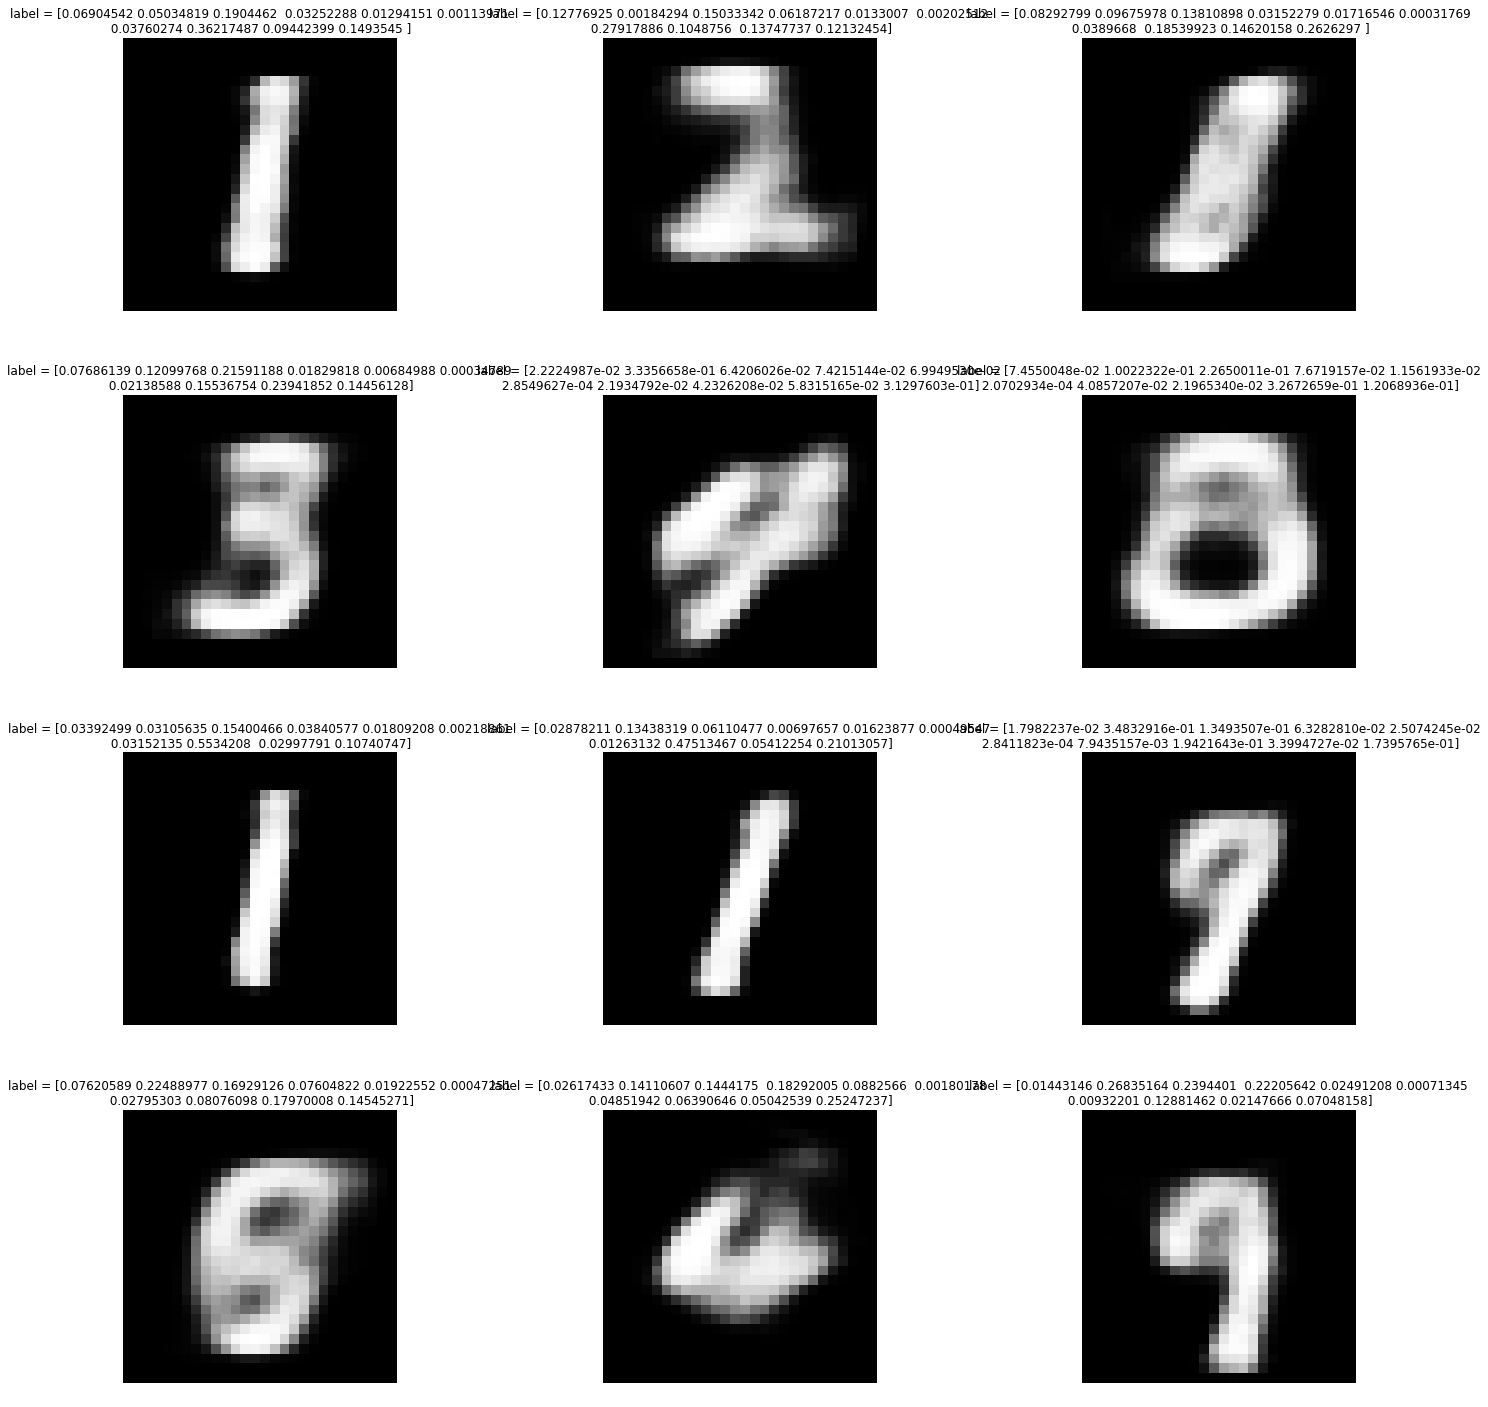

In [66]:
plt.figure(figsize=(20,20))
plot_many_images(x_img, latent_var)

In [48]:
def plot_single_img(img, label):
    pixels = img.reshape((28, 28))

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [66]:
y[4]

9.0

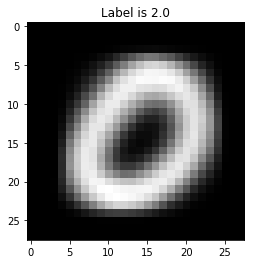

In [68]:
ind = 5
plot_single_img(x_img[ind], y[ind])

Text(0.5,1.05,'Z Samples')

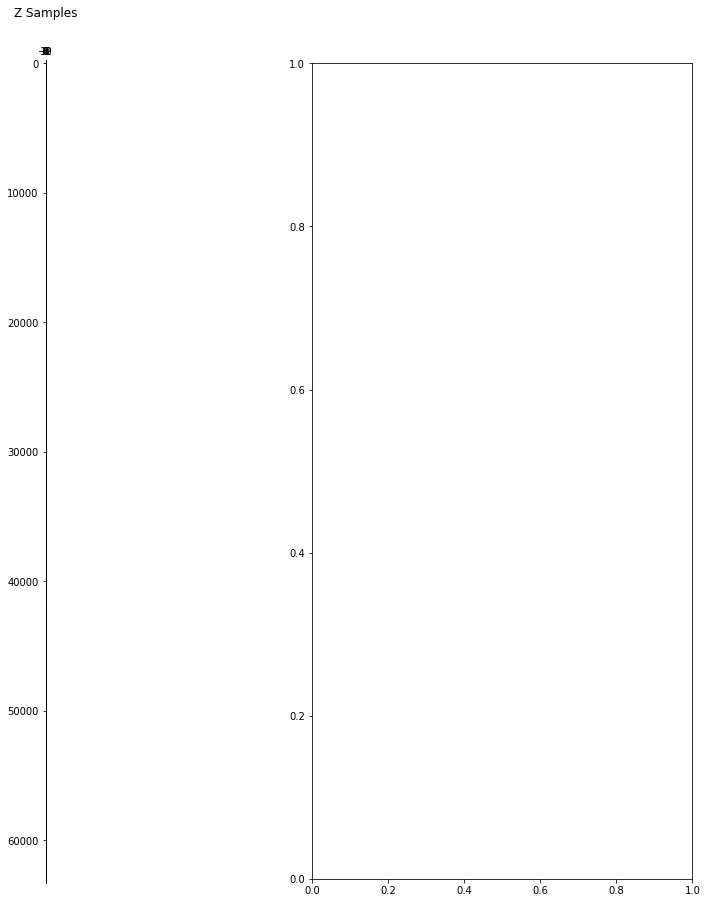

In [35]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_train,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

In [460]:
latent_train.shape

(63000, 2)

In [461]:
class SimpleNN:
    
    def __init__(self, dims):
        self.dims = dims
        self.batch_size = 64
        
        self.x = tf.placeholder(tf.float32, [None, dims[0]])
        self.y_true = tf.placeholder(tf.float32, [None, 10])

#         l1 = DenseLayer(dims[0], dims[1])
#         l2 = DenseLayer(dims[1], 10, f=lambda x: x)
#         tmp = l1.forward(self.x)
#         y_pred = l2.forward(tmp)
        
        layers = []

        in_dim = dims.pop(0)
        for h_dim in dims:
            h = DenseLayer(in_dim, h_dim)
            layers.append(h)
            in_dim = h_dim

        current_value = self.x
        for layer in layers:
            current_value = layer.forward(current_value)
        
        y_pred = current_value

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=self.y_true))
#         self.gd_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
        self.gd_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cross_entropy)
        
        correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y_true, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))
    
    def fit(self, train_input, train_output, test_input, test_output, epochs=10):
        
        n_batches = len(train_input) // self.batch_size
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epochs):
                for j in range(n_batches):
                    batch_x = train_input[j * self.batch_size:(j + 1) * self.batch_size]
                    batch_y = train_output[j * self.batch_size:(j + 1) * self.batch_size]
                    sess.run(self.gd_step, feed_dict={self.x: batch_x, self.y_true: batch_y})

            train_accuracy = sess.run(self.accuracy, feed_dict={self.x: train_input, self.y_true: train_output})
            test_accuracy = sess.run(self.accuracy, feed_dict={self.x: test_input, self.y_true: test_output})
            print("Train accuracy: {:.4}%".format(train_accuracy*100))
            print("Test accuracy: {:.4}%".format(test_accuracy*100))

In [462]:
# simple_nn = SimpleNN([784,512,10])
# simple_nn.fit(X_train, y_train, X_test, y_test)

In [468]:
simple_nn = SimpleNN([10,512, 256, 128, 10])
simple_nn.fit(resp_train, y_train, resp_test, y_test, epochs=10)

Train accuracy: 86.57%
Test accuracy: 85.49%


In [466]:
simple_nn = SimpleNN([2,512, 256, 128, 10])
simple_nn.fit(latent_train, y_train, latent_test, y_test, epochs=10)

Train accuracy: 66.89%
Test accuracy: 66.24%


In [405]:
resp_train.shape

(63000, 10)

In [403]:
np.isnan(resp_train).sum(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [410]:
np.argwhere(np.isnan(resp_train))

array([], shape=(0, 2), dtype=int64)

In [409]:
resp_train[34097,:] = np.zeros(10)
resp_train[40214,:] = np.zeros(10)

In [414]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(resp_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [417]:
rf_predict = clf.predict(resp_test)

In [418]:
calculate_accuracy_np(y_pred=rf_predict, y_true=y_test)

0.6604285714285715

In [ ]:
np.argmax(resp_train, axis=1)

In [352]:
np.argmax(y_train, axis=1)

array([9, 1, 3, ..., 3, 1, 2])

In [354]:
reduced_data = pd.DataFrame({
    'in': np.argmax(resp_train, axis=1),
    'out': np.argmax(y_train, axis=1)
})

In [368]:
aaa = reduced_data[reduced_data['in']==6]

In [369]:
aaa.groupby(['out']).count()

,in
out,
1,1
2,3
3,13
4,468
5,12
6,6
7,50
8,22
9,5912


In [419]:
a = np.array([1,2,3,4])

In [420]:
a[]

4